In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1)) # 保证卷积层的输入与输出尺寸相同 ? - 3 + 2 + 1 = ？
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这个池化层会使得输出的像素尺寸减半 ( ? - 2 + 2 ) / 2 = ? /2
    return nn.Sequential(*layers)

超参数变量conv_arch指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。通道翻倍，输出尺寸减半是深度神经网络常用的设计。

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

共用到了8个卷积层+3个全连接层，这种网络模型被称为VGG-11

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*conv_blks,nn.Flatten(),
                        #全连接层部分
                        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5), # 输入是224 x 224 尺寸经过5个vgg块输出图片7 x 7
                        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
                        nn.Linear(4096, 10))

net = vgg(conv_arch)

接下来，我们将构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。

In [5]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


发现前4个VGG块都会使得通道翻倍，图片像素的尺寸减半

## 训练VGG-11模型
由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch] # 通道减少四倍
net = vgg(small_conv_arch)

loss 0.181, train acc 0.932, test acc 0.915
339.6 examples/sec on cuda:0


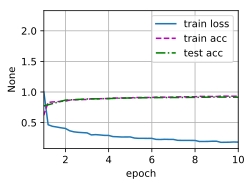

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())